In [1]:
import numpy as np
import matplotlib.pyplot as plt
# Increase font size in figure
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['figure.titlesize'] = 15
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 17
%matplotlib inline

# A simple regression problem

## Data generation

We consider a simple regression problem where $X$ is bivariate gaussian, and $y$ is a linear function of the first coordinate, with noise.

In [2]:
def generate_without_missing_values(n_samples):
    mean = [0, 0]
    cov = [[1, 0.5], [0.5, 1]]
    X = np.random.multivariate_normal(mean, cov, size=n_samples)
    
    epsilon = 0.1 * np.random.randn(n_samples)
    y = X[:, 0] + epsilon
    
    return X, y

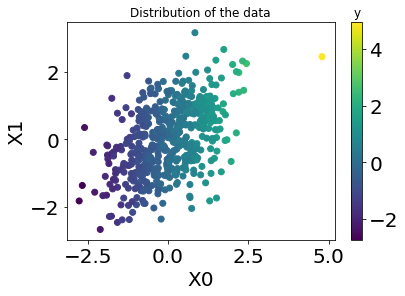

In [3]:
X, y = generate_without_missing_values(500)
plt.scatter(X[:, 0], X[:, 1], c=y);
plt.xlabel("X0")
plt.ylabel("X1")
clb = plt.colorbar()
clb.ax.set_title("y");
plt.title("Distribution of the data");

## Model evaluation

In order to evaluate an estimator, we use the learning curve: the evolution of the (cross-validated) prediction score, in function of the training size.

# Evaluate prediction with missing values

## Data generation: different mechanisms

In the following, we consider two missing data mechanisms: values missing completely at random (on both variables), and values missing only for high values of each variable (censor data).

In [4]:
def generate(n_samples, mechanism, missing_rate=0.2):
    X, y = generate_without_missing_values(n_samples)
    
    if mechanism == 'mcar':
        M = np.random.binomial(1, missing_rate, (n_samples, 2))
    elif mechanism == 'censored':
        B = np.random.binomial(1, 2 * missing_rate, (n_samples, 2))
        M = (X > 0.5) * B
    
    np.putmask(X, M, np.nan)
    
    return X, y

## Different models to try

We compare four missing data methods: imputation by the mean and iterative imputation (each variable is regressed from the other), with or without adding the missing data indicator. This is done both for simple trees and gradient boosted trees.

In [5]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.pipeline import Pipeline

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor


boosting_with_mean_imputation = Pipeline([
    ('Mean imputation', SimpleImputer(strategy='mean')),
    ('Boosting', HistGradientBoostingRegressor(n_iter_no_change=10))
])   
boosting_with_iterative_imputation = Pipeline([
    ('Iterative imputation', IterativeImputer()), 
    ('Boosting', HistGradientBoostingRegressor(n_iter_no_change=10))
])
boosting_with_mean_imputation_and_mask = Pipeline([
    ('Mean imputation and mask', SimpleImputer(strategy='mean', add_indicator=True)), 
    ('Boosting', HistGradientBoostingRegressor(n_iter_no_change=10))
])   
boosting_with_iterative_imputation_and_mask = Pipeline([
    ('Iterative imputation and mask', IterativeImputer(add_indicator=True)), 
    ('Boosting', HistGradientBoostingRegressor(n_iter_no_change=10))
])
boosting_with_MIA_imputation = Pipeline([
    ('Boosting', HistGradientBoostingRegressor(n_iter_no_change=10))
])  # MIA is implemented by default in HistGradientBoostingRegressor in scikit-learn 0.22

boostings = {
    'Mean': boosting_with_mean_imputation,
    'Iterative': boosting_with_iterative_imputation,
    'Mean+mask': boosting_with_mean_imputation_and_mask,
    'Iterative+mask': boosting_with_iterative_imputation_and_mask,
    'NAs in boosted trees\n(MIA)': boosting_with_MIA_imputation
}

## Model evaluation

We still use the learning curve, as well as a boxplot which is easier to read, extracting one slice of the learning curve.

In [6]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score, ShuffleSplit

colors = ['C0', 'C1', 'C2', 'C3', 'black']
figsize = (8, 6)

def plot_learning_curve(estimators, mechanism):
    """ Plot a learning curve for a dictionary of estimators """
    X, y = generate(2 * 10 ** 6, mechanism)
    sizes = np.logspace(2, 4, 5).astype(int)
    
    plt.figure(figsize=figsize)
    for (key, est), color in zip(estimators.items(), colors):
        train_sizes, _, valid_scores = learning_curve(
            est, X, y, train_sizes=sizes, scoring='r2', cv=30, random_state=0,
            n_jobs=-1)
        print('Done with %s' % key)
        
        plt.plot(train_sizes, np.median(valid_scores, axis=1), label=key, color=color)
        plt.fill_between(train_sizes,
            np.percentile(valid_scores, q=25, axis=1),
            np.percentile(valid_scores, q=75, axis=1), alpha=0.2, color=color)
    
    plt.xscale('log')
    plt.legend(loc='best')
    plt.xlabel('Sample size')
    plt.ylabel('r2 score') 
    plt.xlim(train_sizes.min(), train_sizes.max())
    

def boxplot_scores(estimators, n_samples, mechanism):
    """ Plot scores for a dictionary of estimators """
    X, y = generate(2 * 10 ** 6, mechanism)
    
    scores = {}
    plt.figure(figsize=figsize)
    for key, est in estimators.items():
        cv = ShuffleSplit(n_splits=30, train_size=n_samples, random_state=0)
        scores[key] = cross_val_score(
            est, X, y, scoring='r2', cv=cv, n_jobs=-1)
        print('Done with %s' % key)

    bplot = plt.boxplot(list(scores.values())[::-1], labels=list(scores.keys())[::-1],
                vert=False, patch_artist=True)
    # Add colors to boxplots
    for patch, color in zip(bplot['boxes'],
                            colors[::-1]):
        patch.set_facecolor(color)
    plt.title('{}, sample size: {}'.format(mechanism, n_samples), fontsize=20)
    plt.xlabel('r2 score')

### Results

When data is missing completely at random, iterative imputation (with or without the mask) has better finite sample properties than mean imputation: it converges faster. However, for censor data, iterative imputation performs poorly without the help of the indicator, while mean imputation seems self-sufficient.

Done with Mean
Done with Iterative
Done with Mean+mask
Done with Iterative+mask
Done with NAs in boosted trees
(MIA)


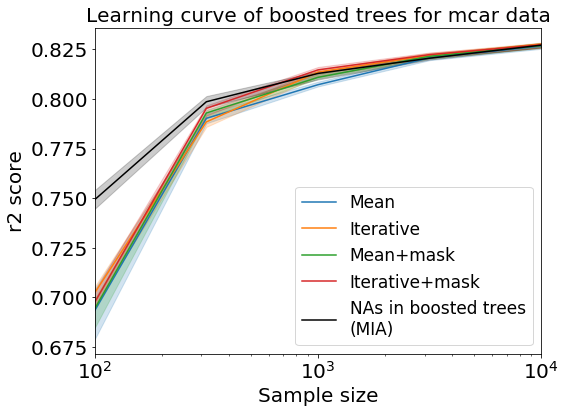

In [7]:
plot_learning_curve(boostings, 'mcar')
plt.title("Learning curve of boosted trees for mcar data", fontsize=20);
plt.savefig('learning_curve_boosting_mcar.svg')
plt.savefig('learning_curve_boosting_mcar.pdf')

Done with Mean
Done with Iterative
Done with Mean+mask
Done with Iterative+mask
Done with NAs in boosted trees
(MIA)


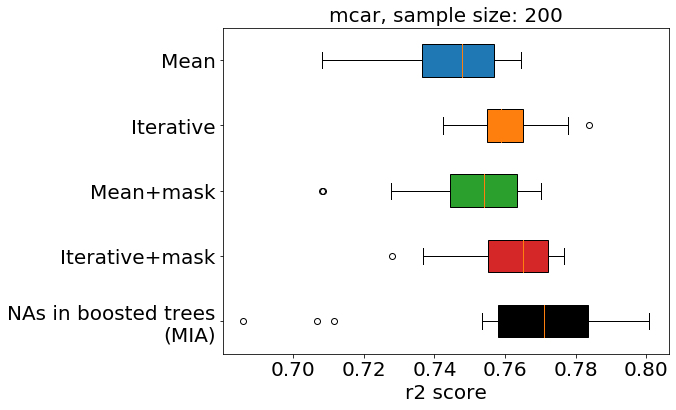

In [8]:
boxplot_scores(boostings, 200, 'mcar')
plt.savefig('boxplot_boosting_mcar.svg')
plt.savefig('boxplot_boosting_mcar.pdf')

Done with Mean
Done with Iterative
Done with Mean+mask
Done with Iterative+mask
Done with NAs in boosted trees
(MIA)


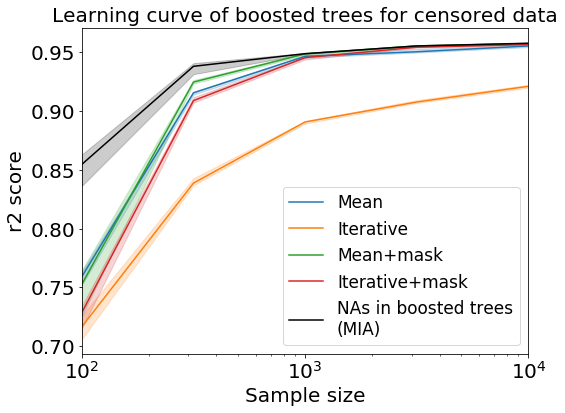

In [9]:
plot_learning_curve(boostings, 'censored')
plt.title("Learning curve of boosted trees for censored data", fontsize=20);
plt.savefig('learning_curve_boosting_censored.svg')
plt.savefig('learning_curve_boosting_censored.pdf')

Done with Mean
Done with Iterative
Done with Mean+mask
Done with Iterative+mask
Done with NAs in boosted trees
(MIA)


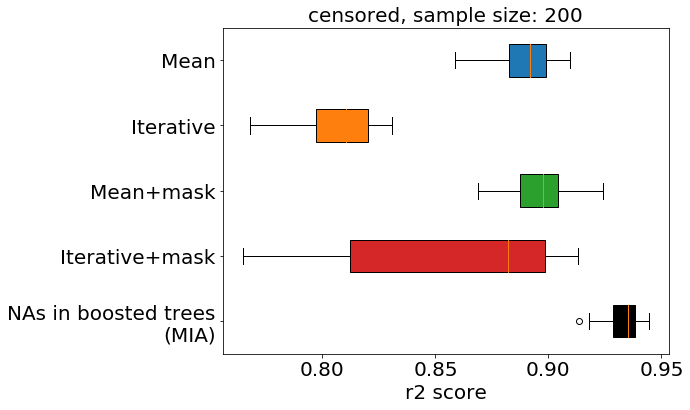

In [10]:
boxplot_scores(boostings, 200, 'censored')
plt.savefig('boxplot_boosting_censored.svg')
plt.savefig('boxplot_boosting_censored.pdf')